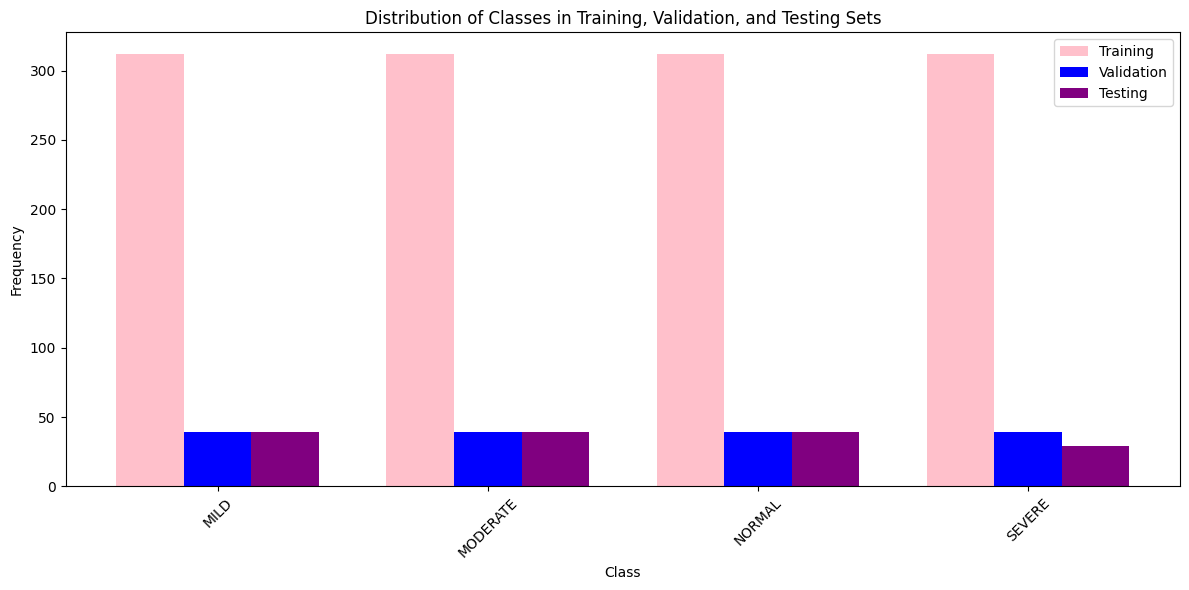

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to load labels from a given directory
def load_labels_from_directory(directory):
    labels = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    labels.append(folder_name)
    return np.array(labels)

# Paths to the directories
train_directory = r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1"
valid_directory = r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1"
test_directory =  r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"

# Load the labels
y_train = load_labels_from_directory(train_directory)
y_val = load_labels_from_directory(valid_directory)
y_test = load_labels_from_directory(test_directory)

# Get the unique classes and their counts for each dataset
(unique_train, counts_train) = np.unique(y_train, return_counts=True)
(unique_val, counts_val) = np.unique(y_val, return_counts=True)
(unique_test, counts_test) = np.unique(y_test, return_counts=True)

# Define the positions for the bars
bar_width = 0.25
index = np.arange(len(unique_train))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars for training, validation, and testing sets with specified colors
bar1 = ax.bar(index, counts_train, bar_width, label='Training', color='pink')
bar2 = ax.bar(index + bar_width, counts_val, bar_width, label='Validation', color='blue')
bar3 = ax.bar(index + 2 * bar_width, counts_test, bar_width, label='Testing', color='purple')

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Classes in Training, Validation, and Testing Sets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(unique_train, rotation=45)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [60]:
# Print the counts for each class in each dataset
print("Training set counts:")
for label, count in zip(unique_train, counts_train):
    print(f"Class {label}: {count} images")

print("\nValidation set counts:")
for label, count in zip(unique_val, counts_val):
    print(f"Class {label}: {count} images")

print("\nTesting set counts:")
for label, count in zip(unique_test, counts_test):
    print(f"Class {label}: {count} images")


Training set counts:
Class MILD: 312 images
Class MODERATE: 312 images
Class NORMAL: 312 images
Class SEVERE: 312 images

Validation set counts:
Class MILD: 39 images
Class MODERATE: 39 images
Class NORMAL: 39 images
Class SEVERE: 39 images

Testing set counts:
Class MILD: 39 images
Class MODERATE: 39 images
Class NORMAL: 39 images
Class SEVERE: 29 images


GLCM CROP CITRA RF

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=65, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate accuracy on the test set
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

# Predict the classes for the new data
predicted_classes = rf_classifier.predict(X)

# Print the predicted and actual classes for each image
for i, (predicted_class, actual_class) in enumerate(zip(predicted_classes, y)):
    print(f"Image {i + 1} is classified as: {predicted_class}, Actual Class: {actual_class}")

# Calculate the confusion matrix
cm = confusion_matrix(y, predicted_classes)

# Define class names
class_names = list(set(y))

# Function to calculate sensitivity and specificity
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
    
    return sensitivity, specificity

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_metrics(cm)

# Print classification report
report = classification_report(y, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Print sensitivity and specificity for each class
print("Sensitivity and Specificity for each class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name} - Sensitivity (Recall): {sensitivity[i]:.4f}, Specificity: {specificity[i]:.4f}')

# Function to plot confusion matrix with custom color map
def plot_cm(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



Accuracy: 0.9666666666666667
Image 1 is classified as: MILD, Actual Class: MILD
Image 2 is classified as: MILD, Actual Class: MILD
Image 3 is classified as: MILD, Actual Class: MILD
Image 4 is classified as: MILD, Actual Class: MILD
Image 5 is classified as: MILD, Actual Class: MILD
Image 6 is classified as: MILD, Actual Class: MILD
Image 7 is classified as: MILD, Actual Class: MILD
Image 8 is classified as: MILD, Actual Class: MILD
Image 9 is classified as: MILD, Actual Class: MILD
Image 10 is classified as: MILD, Actual Class: MILD
Image 11 is classified as: MILD, Actual Class: MILD
Image 12 is classified as: MILD, Actual Class: MILD
Image 13 is classified as: MILD, Actual Class: MILD
Image 14 is classified as: MILD, Actual Class: MILD
Image 15 is classified as: MILD, Actual Class: MILD
Image 16 is classified as: MILD, Actual Class: MILD
Image 17 is classified as: MILD, Actual Class: MILD
Image 18 is classified as: MILD, Actual Class: MILD
Image 19 is classified as: MILD, Actual Clas

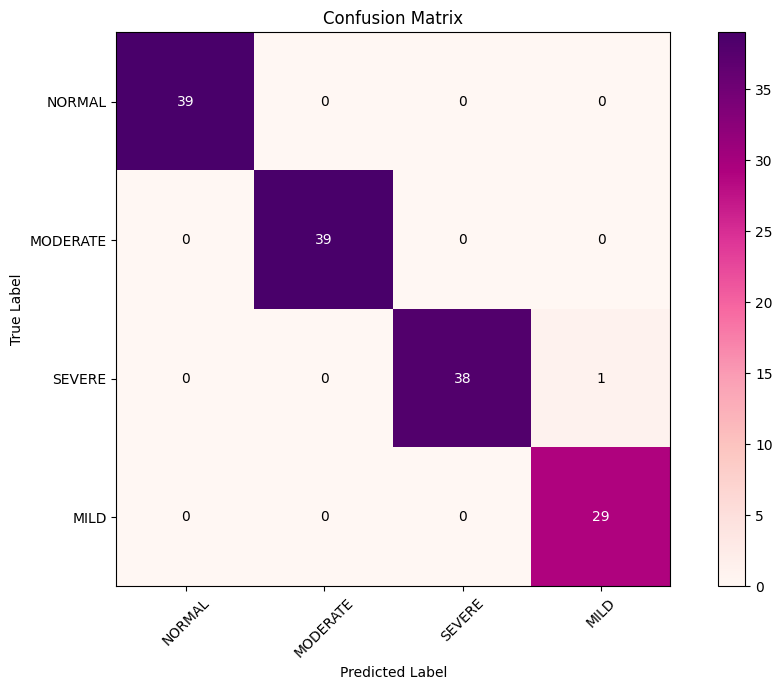

In [13]:
# Plot confusion matrix with custom color map
plot_cm(cm, class_names)

SVM KERNEL RBF

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0

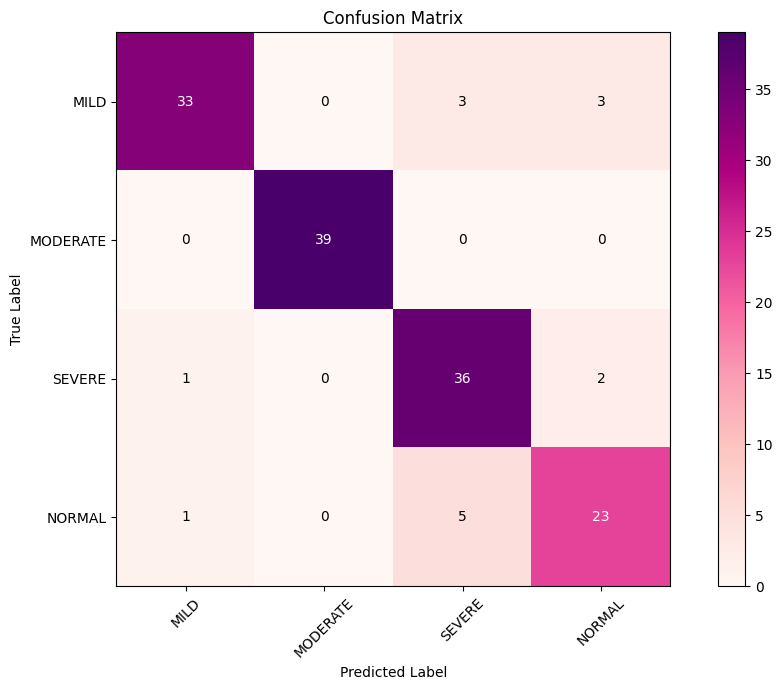

In [34]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pickle

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\RBF SINGLE'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', random_state=42)

# Set the parameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=2, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Save the best model to a .pkl file
model_filepath = os.path.join(excel_output_path, 'svm(1)_model.pkl')
with open(model_filepath, 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)
print(f"SVM model saved to {model_filepath}")

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Evaluate accuracy on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict the classes for the new data
predicted_classes = grid_search.predict(X)

# Print the predicted and actual classes for each image
output_results_filepath = os.path.join(excel_output_path, 'output_results.txt')
with open(output_results_filepath, 'w') as file:
    file.write("Predicted vs Actual Classes:\n")
    for i, (predicted_class, actual_class) in enumerate(zip(predicted_classes, y)):
        file.write(f"Image {i + 1} is classified as: {predicted_class}, Actual Class: {actual_class}\n")
print(f"Predicted vs Actual Classes saved to {output_results_filepath}")

# Calculate the confusion matrix
cm = confusion_matrix(y, predicted_classes)

# Define class names
class_names = list(set(y))

# Function to calculate sensitivity and specificity
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
    
    return sensitivity, specificity

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_metrics(cm)

# Print classification report
report = classification_report(y, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Print sensitivity and specificity for each class
print("Sensitivity and Specificity for each class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name} - Sensitivity (Recall): {sensitivity[i]:.4f}, Specificity: {specificity[i]:.4f}')

# Function to plot confusion matrix with custom color map
def plot_cm(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Save results of GridSearchCV to Excel
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results_filepath = os.path.join(excel_output_path, 'grid_search_results.xlsx')
grid_search_results.to_excel(grid_search_results_filepath, index=False)
print(f"Grid Search results saved to {grid_search_results_filepath}")

# Plot the confusion matrix
plot_cm(cm, class_names)


BEST PARAMETER TUNING KERNEL RBF

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\RBF'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# List of random states to test
random_states = [20, 42, 100, 150]

# Function to calculate sensitivity, specificity, and precision
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
        precision[i] = tp / (tp + fp)
    
    return sensitivity, specificity, precision

# Define the parameter grid for GridSearchCV
param_grid = [
    {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
]

# Perform hyperparameter tuning with GridSearchCV
results_grid_search = []

for random_state in random_states:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(random_state))

    # Initialize the SVM classifier
    svm = SVC(random_state=int(random_state))

    # Initialize GridSearchCV
    grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Predictions using the best model
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Calculate metrics
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    train_acc = accuracy_score(y_train, y_pred_train) * 100
    test_acc = accuracy_score(y_test, y_pred_test) * 100

    sensitivity_train, specificity_train, precision_train = calculate_metrics(cm_train)
    sensitivity_test, specificity_test, precision_test = calculate_metrics(cm_test)

    results_grid_search.append({
        'Random State': int(random_state),
        'Best Params': best_params,
        'Best Score': best_score,
        'Train Accuracy (%)': train_acc,
        'Test Accuracy (%)': test_acc,
        'Train Sensitivity (%)': np.mean(sensitivity_train) * 100,
        'Test Sensitivity (%)': np.mean(sensitivity_test) * 100,
        'Train Specificity (%)': np.mean(specificity_train) * 100,
        'Test Specificity (%)': np.mean(specificity_test) * 100,
        'Train Precision (%)': np.mean(precision_train) * 100,
        'Test Precision (%)': np.mean(precision_test) * 100
    })

# Create DataFrame to store results of GridSearchCV
df_grid_search_results = pd.DataFrame(results_grid_search)

# Save results of GridSearchCV to Excel
grid_search_results_filepath = os.path.join(excel_output_path, 'grid_search_results.xlsx')
df_grid_search_results.to_excel(grid_search_results_filepath, index=False)
print(f"Grid Search results saved to {grid_search_results_filepath}")

# Print Grid Search results in table format
print(df_grid_search_results)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Grid Search results saved to C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\RBF\grid_search_results.xlsx
   Random State                                 Best Params  Best Score  \
0            20    {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}    0.759058   
1            42      {'C': 10, 'gamma': 1, 'kernel': 'rbf'}    0.792391   
2           100     {'C': 100, 'gamma': 1, 'kernel': 'rbf'}    0.792754   
3           150  {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}    0.828261   

   Train Accuracy (%)  Test Accuracy (%)  Train Sensitivity (%)  \
0          100.000000          80.000000             100.000000   
1           93.103448          76.666667              92.675890   
2           97.413793          83.333333        

HYPERPARAMETER TUNING FINAL RBF 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0

c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

         C  Gamma  Akurasi (%)  Sensitivitas (%)  Spesifisitas (%)  \
0      0.1  0.001    76.666667         69.375000         91.931818   
1      0.1  0.010    73.333333         66.875000         90.795455   
2      0.1  0.100    70.000000         65.000000         89.772727   
3      0.1  1.000    46.666667         46.428571         81.818182   
4      1.0  0.001    73.333333         66.875000         90.795455   
5      1.0  0.010    73.333333         66.875000         90.795455   
6      1.0  0.100    70.000000         65.625000         90.204545   
7      1.0  1.000    76.666667         74.375000         92.340909   
8     10.0  0.001    70.000000         64.375000         90.045455   
9     10.0  0.010    73.333333         66.875000         90.795455   
10    10.0  0.100    70.000000         65.625000         89.477273   
11    10.0  1.000    76.666667         74.375000         92.340909   
12   100.0  0.001    73.333333         67.500000         90.909091   
13   100.0  0.010   

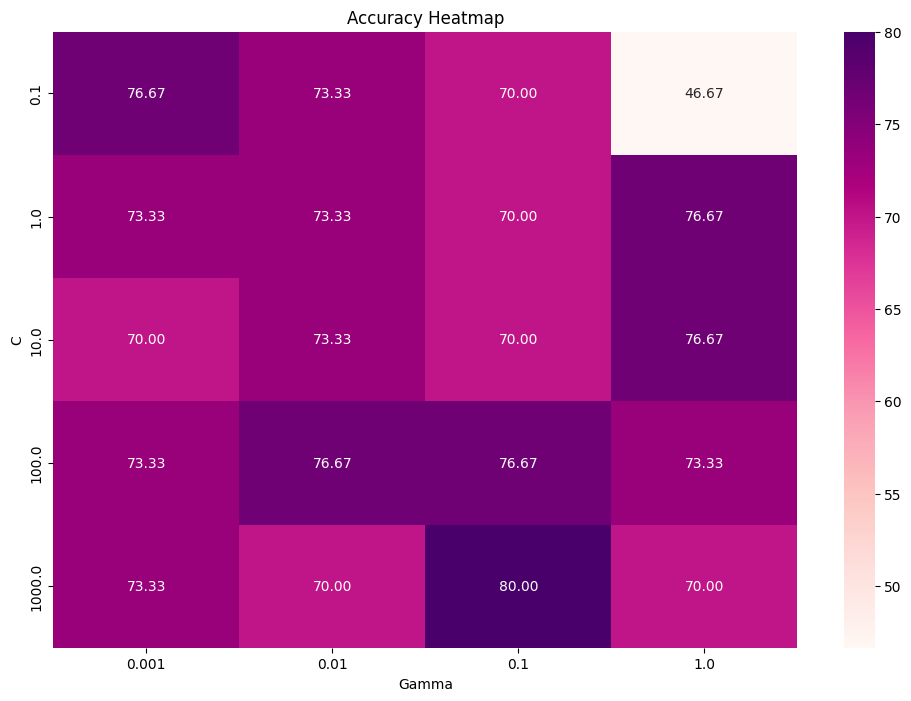

Model terbaik disimpan di: best_svm_model.pkl

Classification Report (Best Model - Highest Accuracy):
              precision    recall  f1-score   support

        MILD       0.80      0.80      0.80        10
    MODERATE       1.00      1.00      1.00         7
      NORMAL       0.70      0.88      0.78         8
      SEVERE       0.67      0.40      0.50         5

    accuracy                           0.80        30
   macro avg       0.79      0.77      0.77        30
weighted avg       0.80      0.80      0.79        30


Parameter terbaik (C, Gamma): (1000.0, 0.1)
Grid Search results saved to ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\SPESIFITAS\RBF\grid_search_results.xlsx


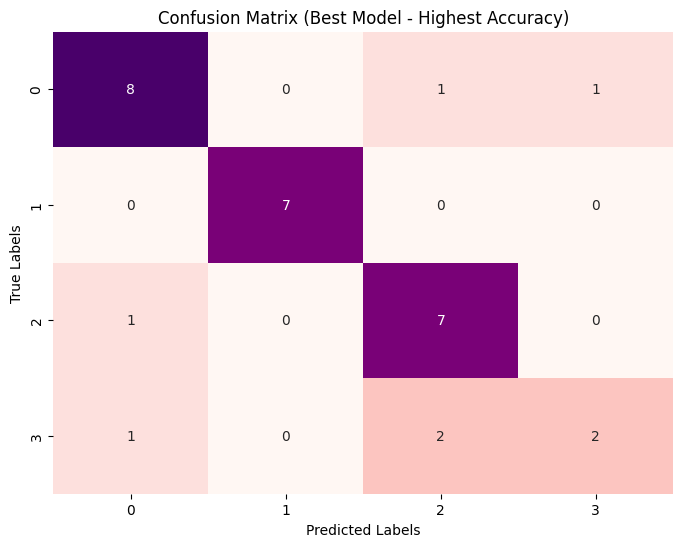

In [57]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\SPESIFITAS\RBF'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', random_state=42)

# Set the parameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=2, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Function to calculate specificity for multi-class classification using one-vs-rest approach
def specificity_score_multiclass(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity_per_class = []
    
    for i in range(cm.shape[0]):
        true_positive = cm[i, i]
        false_positive = cm[:, i].sum() - true_positive
        false_negative = cm[i, :].sum() - true_positive
        true_negative = cm.sum() - (true_positive + false_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)
        specificity_per_class.append(specificity)
    
    return np.mean(specificity_per_class)

# Create table of results
results = pd.DataFrame(grid_search.cv_results_)
table_results = []

for i in range(len(results)):
    params = results.iloc[i]
    model = SVC(C=params['param_C'], gamma=params['param_gamma'], kernel='rbf').fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    sensitivity = recall_score(y_test, y_pred, average='macro') * 100
    specificity = specificity_score_multiclass(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='macro') * 100
    
    table_results.append({
        'C': params['param_C'],
        'Gamma': params['param_gamma'],
        'Akurasi (%)': accuracy,
        'Sensitivitas (%)': sensitivity,
        'Spesifisitas (%)': specificity,
        'Presisi (%)': precision
    })

# Convert to DataFrame
table_results_df = pd.DataFrame(table_results)

# Display the table
print(table_results_df)

# Create pivot table for the heatmap
pivot_table = table_results_df.pivot(index='C', columns='Gamma', values='Akurasi (%)')

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=plt.cm.RdPu, ax=ax)
plt.title('Accuracy Heatmap')
plt.show()

# Temukan baris dengan akurasi tertinggi
best_result_row = table_results_df.loc[table_results_df['Akurasi (%)'].idxmax()]

# Dapatkan nilai C dan Gamma dari baris terbaik
best_C = best_result_row['C']
best_gamma = best_result_row['Gamma']

# Buat dan fit ulang model SVC dengan parameter terbaik
best_model = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
best_model.fit(X_train, y_train)

# Simpan model terbaik ke dalam file pickle
model_filename = 'best_svm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
    print(f"Model terbaik disimpan di: {model_filename}")

# Lakukan prediksi dengan model terbaik pada data uji
best_predictions = best_model.predict(X_test)

# Cetak classification report untuk hasil prediksi terbaik
print("\nClassification Report (Best Model - Highest Accuracy):")
print(classification_report(y_test, best_predictions))

# Cetak juga nilai parameter C dan Gamma yang digunakan
print(f"\nParameter terbaik (C, Gamma): ({best_C}, {best_gamma})")

# Hitung confusion matrix dari prediksi terbaik
cm = confusion_matrix(y_test, best_predictions)

# Save results of GridSearchCV to Excel
grid_search_results_filepath = os.path.join(excel_output_path, 'grid_search_results.xlsx')
results.to_excel(grid_search_results_filepath, index=False)
print(f"Grid Search results saved to {grid_search_results_filepath}")

# Plot heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.RdPu, fmt="d", cbar=False)
plt.title('Confusion Matrix (Best Model - Highest Accuracy)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


SVM KERNEL SYGMOID

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1

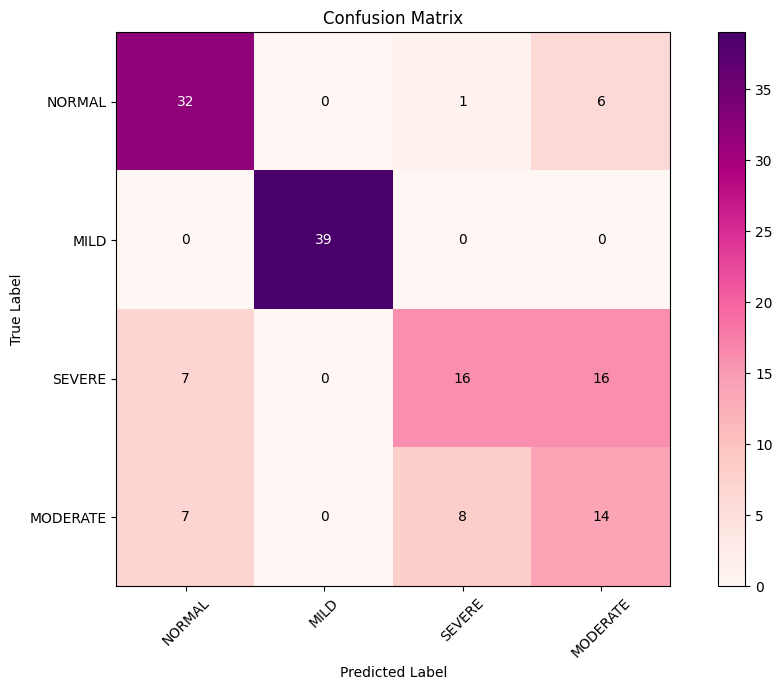

: 

In [33]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\Sigmoid'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier with Sigmoid kernel
svm_classifier = SVC(kernel='sigmoid', random_state=42)

# Set the parameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=2, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Evaluate accuracy on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict the classes for the new data
predicted_classes = grid_search.predict(X)

# Print the predicted and actual classes for each image
for i, (predicted_class, actual_class) in enumerate(zip(predicted_classes, y)):
    print(f"Image {i + 1} is classified as: {predicted_class}, Actual Class: {actual_class}")

# Calculate the confusion matrix
cm = confusion_matrix(y, predicted_classes)

# Define class names
class_names = list(set(y))

# Function to calculate sensitivity and specificity
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
    
    return sensitivity, specificity

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_metrics(cm)

# Print classification report
report = classification_report(y, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Print sensitivity and specificity for each class
print("Sensitivity and Specificity for each class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name} - Sensitivity (Recall): {sensitivity[i]:.4f}, Specificity: {specificity[i]:.4f}')

# Function to plot confusion matrix with custom color map
def plot_cm(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
plot_cm(cm, class_names)


HYPERPARAMETER FINAL SIGMOID

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................C=0.1, coef0=0.0; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.0; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.0; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.0; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.0; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.1; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.1; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.1; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.1; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.1; total time=   0.0s
[CV] END ...................................C=0.1, coef0=0.5; total time=   0.0s
[CV] END ...................................C=0

c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

         C  coef0  Akurasi (%)  Sensitivitas (%)  Spesifisitas (%)  \
0      0.1    0.0    50.000000         50.000000         82.954545   
1      0.1    0.1    50.000000         50.000000         82.954545   
2      0.1    0.5    23.333333         25.000000         75.000000   
3      0.1    1.0    23.333333         25.000000         75.000000   
4      1.0    0.0    33.333333         33.750000         76.136364   
5      1.0    0.1    33.333333         33.750000         76.136364   
6      1.0    0.5    36.666667         37.053571         77.727273   
7      1.0    1.0    46.666667         46.428571         81.704545   
8     10.0    0.0    43.333333         48.750000         81.136364   
9     10.0    0.1    43.333333         48.750000         81.136364   
10    10.0    0.5    30.000000         30.178571         74.886364   
11    10.0    1.0    30.000000         30.178571         74.886364   
12   100.0    0.0    70.000000         68.750000         90.227273   
13   100.0    0.1   

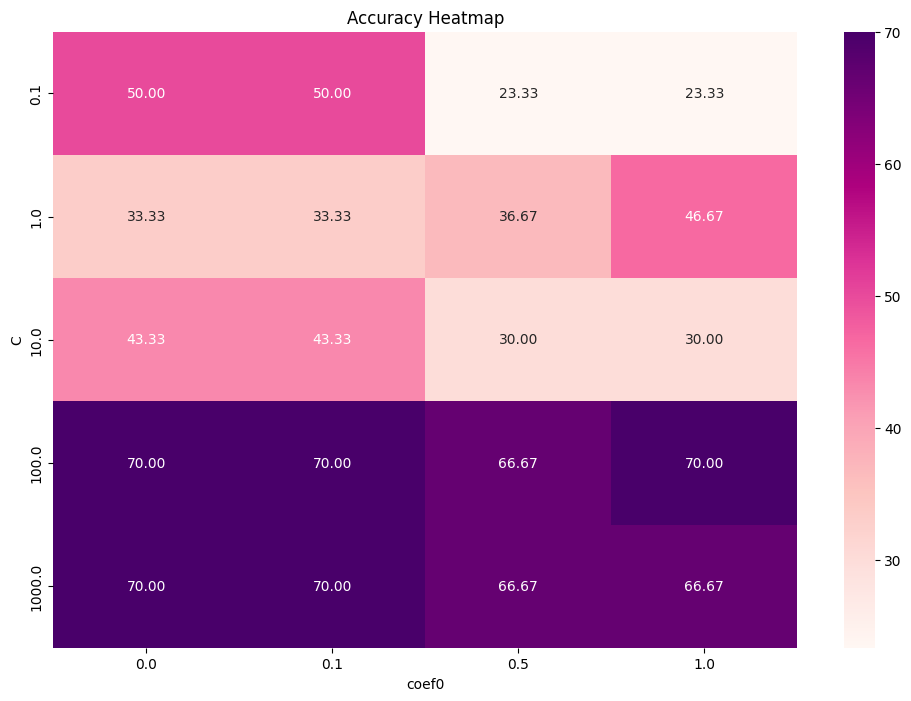

Model terbaik disimpan di: best_svm_model_sigmoid.pkl

Classification Report (Best Model - Highest Accuracy):
              precision    recall  f1-score   support

        MILD       0.82      0.90      0.86        10
    MODERATE       1.00      1.00      1.00         7
      NORMAL       0.50      0.25      0.33         8
      SEVERE       0.38      0.60      0.46         5

    accuracy                           0.70        30
   macro avg       0.67      0.69      0.66        30
weighted avg       0.70      0.70      0.68        30


Parameter terbaik (C, coef0): (100.0, 0.0)
Grid Search results saved to C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\SPESIFITAS\SIGMO\grid_search_results_sigmoid.xlsx


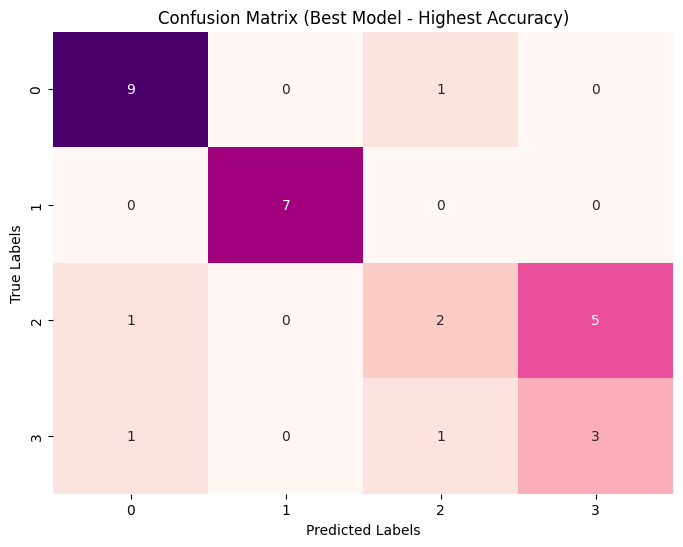

In [54]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\SPESIFITAS\SIGMO'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier with sigmoid kernel
svm_classifier = SVC(kernel='sigmoid', random_state=42)

# Set the parameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=2, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Function to calculate specificity for multi-class classification
def specificity_score_multiclass(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity_per_class = []
    
    for i in range(cm.shape[0]):
        true_negative = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        false_positive = np.sum(cm[:, i]) - cm[i, i]
        specificity = true_negative / (true_negative + false_positive)
        specificity_per_class.append(specificity)
    
    return specificity_per_class

# Create table of results
results = pd.DataFrame(grid_search.cv_results_)
table_results = []

for i in range(len(results)):
    params = results.iloc[i]
    model = SVC(C=params['param_C'], coef0=params['param_coef0'], kernel='sigmoid').fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    sensitivity = recall_score(y_test, y_pred, average='macro') * 100
    specificity_per_class = specificity_score_multiclass(y_test, y_pred)
    specificity = np.mean(specificity_per_class) * 100
    precision = precision_score(y_test, y_pred, average='macro') * 100
    
    table_results.append({
        'C': params['param_C'],
        'coef0': params['param_coef0'],
        'Akurasi (%)': accuracy,
        'Sensitivitas (%)': sensitivity,
        'Spesifisitas (%)': specificity,
        'Presisi (%)': precision
    })

# Convert to DataFrame
table_results_df = pd.DataFrame(table_results)

# Display the table
print(table_results_df)

# Create pivot table for the heatmap
pivot_table = table_results_df.pivot(index='C', columns='coef0', values='Akurasi (%)')

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=plt.cm.RdPu, ax=ax)
plt.title('Accuracy Heatmap')
plt.show()

# Temukan baris dengan akurasi tertinggi
best_result_row = table_results_df.loc[table_results_df['Akurasi (%)'].idxmax()]

# Dapatkan nilai C dan Gamma dari baris terbaik
best_C = best_result_row['C']
best_coef0 = best_result_row['coef0']

# Buat dan fit ulang model SVC dengan parameter terbaik
best_model = SVC(C=best_C, coef0=best_coef0, kernel='sigmoid')
best_model.fit(X_train, y_train)

# Simpan model terbaik ke dalam file pickle
model_filename = 'best_svm_model_sigmoid.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
    print(f"Model terbaik disimpan di: {model_filename}")

# Lakukan prediksi dengan model terbaik pada data uji
best_predictions = best_model.predict(X_test)

# Cetak classification report untuk hasil prediksi terbaik
print("\nClassification Report (Best Model - Highest Accuracy):")
print(classification_report(y_test, best_predictions))

# Cetak juga nilai parameter C dan coef0 yang digunakan
print(f"\nParameter terbaik (C, coef0): ({best_C}, {best_coef0})")

# Hitung confusion matrix dari prediksi terbaik
cm = confusion_matrix(y_test, best_predictions)

# Save results of GridSearchCV to Excel
grid_search_results_filepath = os.path.join(excel_output_path, 'grid_search_results_sigmoid.xlsx')
results.to_excel(grid_search_results_filepath, index=False)
print(f"Grid Search results saved to {grid_search_results_filepath}")

# Plot heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.RdPu, fmt="d", cbar=False)
plt.title('Confusion Matrix (Best Model - Highest Accuracy)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


SVM KERNEL POLYNOMIAL

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................................C=0.1, degree=2; total time=   0.1s
[CV] END ....................................C=0.1, degree=2; total time=   0.1s
[CV] END ....................................C=0.1, degree=2; total time=   0.1s
[CV] END ....................................C=0.1, degree=2; total time=   0.0s
[CV] END ....................................C=0.1, degree=2; total time=   0.1s
[CV] END ....................................C=0.1, degree=3; total time=   0.1s
[CV] END ....................................C=0.1, degree=3; total time=   0.1s
[CV] END ....................................C=0.1, degree=3; total time=   0.1s
[CV] END ....................................C=0.1, degree=3; total time=   0.0s
[CV] END ....................................C=0.1, degree=3; total time=   0.1s
[CV] END ....................................C=0.1, degree=4; total time=   0.1s
[CV] END ....................................C=0

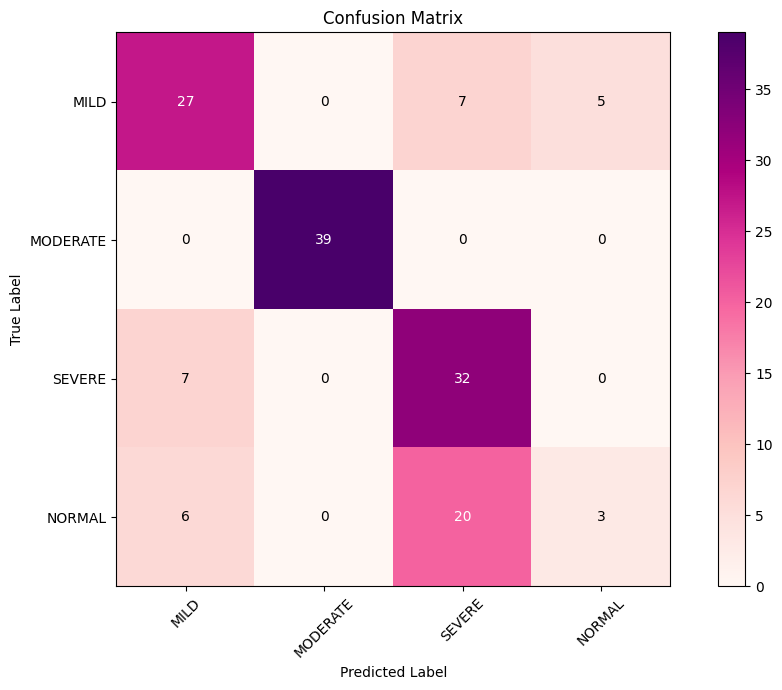

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import joblib

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\polynomial'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier with polynomial kernel
svm_classifier = SVC(kernel='poly', random_state=42)

# Set the parameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    #'gamma': [1, 0.1, 0.01, 0.001],
    'degree': [2, 3, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=2, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Save the best model
model_path = os.path.join(excel_output_path, 'best_svm_model_poly.pkl')
joblib.dump(grid_search.best_estimator_, model_path)
print(f"Model saved to {model_path}")

# Evaluate accuracy on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict the classes for the new data
predicted_classes = grid_search.predict(X)

# Print the predicted and actual classes for each image
for i, (predicted_class, actual_class) in enumerate(zip(predicted_classes, y)):
    print(f"Image {i + 1} is classified as: {predicted_class}, Actual Class: {actual_class}")

# Calculate the confusion matrix
cm = confusion_matrix(y, predicted_classes)

# Define class names
class_names = list(set(y))

# Function to calculate sensitivity and specificity
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
    
    return sensitivity, specificity

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_metrics(cm)

# Print classification report
report = classification_report(y, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Print sensitivity and specificity for each class
print("Sensitivity and Specificity for each class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name} - Sensitivity (Recall): {sensitivity[i]:.4f}, Specificity: {specificity[i]:.4f}')

# Function to plot confusion matrix with custom color map
def plot_cm(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
plot_cm(cm, class_names)


HYPERPARAMATER TUNING FINAL POLYNOMIAL

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ....................................C=0.1, degree=2; total time=   0.0s
[CV] END ....................................C=0.1, degree=2; total time=   0.0s
[CV] END ....................................C=0.1, degree=2; total time=   0.0s
[CV] END ....................................C=0.1, degree=2; total time=   0.0s
[CV] END ....................................C=0.1, degree=2; total time=   0.0s
[CV] END ....................................C=0.1, degree=3; total time=   0.0s
[CV] END ....................................C=0.1, degree=3; total time=   0.0s
[CV] END ....................................C=0.1, degree=3; total time=   0.0s
[CV] END ....................................C=0.1, degree=3; total time=   0.0s
[CV] END ....................................C=0.1, degree=3; total time=   0.0s
[CV] END ....................................C=0.1, degree=4; total time=   0.0s
[CV] END ....................................C=

c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

         C  degree  Akurasi (%)  Sensitivitas (%)  Spesifisitas (%)  \
0      0.1       2    63.333333            57.500         87.534585   
1      0.1       3    60.000000            55.000         86.883399   
2      0.1       4    53.333333            48.750         84.323123   
3      0.1       5    56.666667            51.875         85.573123   
4      1.0       2    76.666667            71.875         92.068182   
5      1.0       3    70.000000            64.375         90.045455   
6      1.0       4    66.666667            61.250         88.572134   
7      1.0       5    70.000000            64.375         89.822134   
8     10.0       2    76.666667            71.875         92.068182   
9     10.0       3    70.000000            64.375         90.045455   
10    10.0       4    73.333333            67.500         90.909091   
11    10.0       5    73.333333            67.500         90.909091   
12   100.0       2    76.666667            71.875         92.068182   
13   1

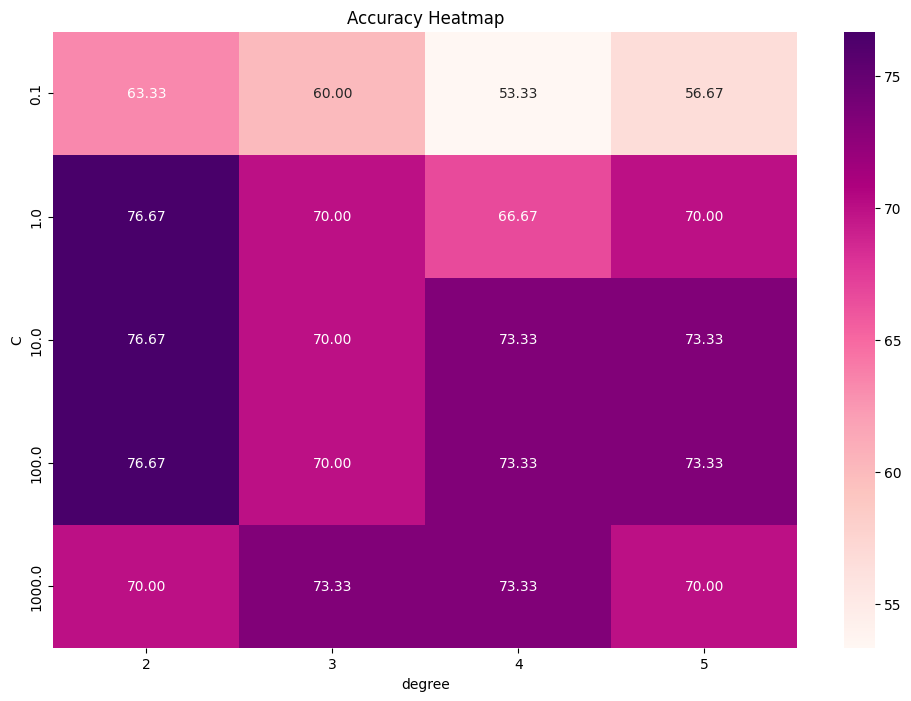

Model terbaik disimpan di: best_svm_model_poly1.pkl

Classification Report (Best Model - Highest Accuracy):
              precision    recall  f1-score   support

        MILD       0.89      0.80      0.84        10
    MODERATE       1.00      1.00      1.00         7
      NORMAL       0.58      0.88      0.70         8
      SEVERE       0.50      0.20      0.29         5

    accuracy                           0.77        30
   macro avg       0.74      0.72      0.71        30
weighted avg       0.77      0.77      0.75        30


Parameter terbaik (C, degree): (1.0, 2)
Grid Search results saved to C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\SPESIFITAS\POLY\grid_search_results_poly.xlsx


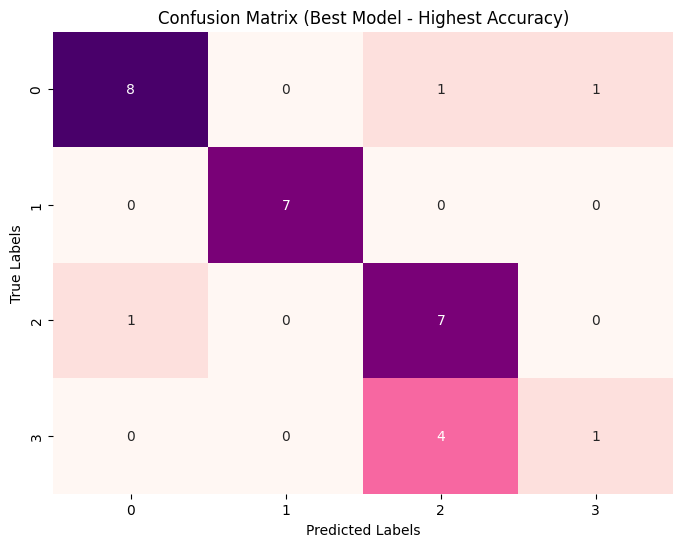

In [56]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Function to extract GLCM features from a grayscale image
def extract_glcm_features(image):
    try:
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        levels = 256
        glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
            'variance': np.var(glcm.flatten())
        }
        return features
    except Exception as e:
        print(f"Error extracting GLCM features: {e}")
        return None

# Function to process images in a directory and extract features
def process_directory(directory_path, excel_output_path):
    results = {}
    if not os.path.exists(directory_path):
        print(f"Error: Directory does not exist: {directory_path}")
        return results

    if not os.path.exists(excel_output_path):
        os.makedirs(excel_output_path)

    classes = os.listdir(directory_path)
    for class_name in classes:
        class_directory = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_directory):
            continue

        class_results = []
        for filename in os.listdir(class_directory):
            if filename.lower().endswith(('png', 'jpg', 'bmp')):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    features = extract_glcm_features(gray)
                    if features is not None:
                        class_results.append({
                            'filename': filename,
                            **features
                        })
                else:
                    print(f"Error: Unable to read image at path: {image_path}")
        results[class_name] = class_results

    # Convert results to DataFrame and save to Excel
    for class_name, images in results.items():
        df = pd.DataFrame(images)
        excel_filename = f"{class_name}_glcm_features.xlsx"
        excel_filepath = os.path.join(excel_output_path, excel_filename)
        df.to_excel(excel_filepath, index=False)

    return results

# Example usage to process multiple directories
main_directory_paths = [
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TRAIN 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\VAL 1",
    r"C:\Users\lenovo\Downloads\TA\ORIGA DATASET\image cropped class\image orii\TEST 1"
]
excel_output_path = r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\SPESIFITAS\POLY'

all_results = {}

for directory_path in main_directory_paths:
    dir_results = process_directory(directory_path, excel_output_path)
    all_results.update(dir_results)

# Extract features and labels for classification
X = []  # Feature vectors
y = []  # Class labels

for class_name, images in all_results.items():
    for image_data in images:
        feature_vector = [
            image_data['contrast'],
            image_data['dissimilarity'],
            image_data['homogeneity'],
            image_data['energy'],
            image_data['correlation'],
            image_data['ASM'],
            image_data['variance']
        ]
        X.append(feature_vector)
        y.append(class_name)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier with polynomial kernel
svm_classifier = SVC(kernel='poly', random_state=42)

# Set the parameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'degree': [2, 3, 4, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=2, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Function to calculate specificity for multi-class classification using one-vs-rest approach
def specificity_score_multiclass(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity_per_class = []
    
    for i in range(cm.shape[0]):
        true_negative = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        false_positive = np.sum(cm[:, i]) - cm[i, i]
        specificity = true_negative / (true_negative + false_positive)
        specificity_per_class.append(specificity)
    
    return np.mean(specificity_per_class)

# Create table of results
results = pd.DataFrame(grid_search.cv_results_)
table_results = []

for i in range(len(results)):
    params = results.iloc[i]
    model = SVC(C=params['param_C'], degree=int(params['param_degree']), kernel='poly').fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    sensitivity = recall_score(y_test, y_pred, average='macro') * 100
    specificity = specificity_score_multiclass(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='macro') * 100
    
    table_results.append({
        'C': params['param_C'],
        'degree': params['param_degree'],
        'Akurasi (%)': accuracy,
        'Sensitivitas (%)': sensitivity,
        'Spesifisitas (%)': specificity,
        'Presisi (%)': precision
    })

# Convert to DataFrame
table_results_df = pd.DataFrame(table_results)

# Display the table
print(table_results_df)

# Create pivot table for the heatmap
pivot_table = table_results_df.pivot(index='C', columns='degree', values='Akurasi (%)')

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=plt.cm.RdPu, ax=ax)
plt.title('Accuracy Heatmap')
plt.show()

# Temukan baris dengan akurasi tertinggi
best_result_row = table_results_df.loc[table_results_df['Akurasi (%)'].idxmax()]

# Dapatkan nilai C dan degree dari baris terbaik
best_C = best_result_row['C']
best_degree = int(best_result_row['degree'])

# Buat dan fit ulang model SVC dengan parameter terbaik
best_model = SVC(C=best_C, degree=best_degree, kernel='poly')
best_model.fit(X_train, y_train)

# Simpan model terbaik ke dalam file pickle
model_filename = 'best_svm_model_poly1.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
    print(f"Model terbaik disimpan di: {model_filename}")

# Lakukan prediksi dengan model terbaik pada data uji
best_predictions = best_model.predict(X_test)

# Cetak classification report untuk hasil prediksi terbaik
print("\nClassification Report (Best Model - Highest Accuracy):")
print(classification_report(y_test, best_predictions))

# Cetak juga nilai parameter C dan degree yang digunakan
print(f"\nParameter terbaik (C, degree): ({best_C}, {best_degree})")

# Hitung confusion matrix dari prediksi terbaik
cm = confusion_matrix(y_test, best_predictions)

# Save results of GridSearchCV to Excel
grid_search_results_filepath = os.path.join(excel_output_path, 'grid_search_results_poly.xlsx')
results.to_excel(grid_search_results_filepath, index=False)
print(f"Grid Search results saved to {grid_search_results_filepath}")

# Plot heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.RdPu, fmt="d", cbar=False)
plt.title('Confusion Matrix (Best Model - Highest Accuracy)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


PCC ANTAR KELAS

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Contoh data
data = {
    'Contrast': [30.081714, 34.0749817, 2.238147158, 46.61760583],
    'Dissimilarity': [3.749947388, 3.707482137, 0.96146562012, 4.665481922],
    'Correlation': [0.98551439, 0.98940448, 0.998263918, 0.992778992],
    'Energy': [0.02869948, 0.05977389, 0.052621093, 0.038941078],
    'Homogeneity': [0.30079209, 0.30079209, 0.628445273, 0.276558079],
    'Class': [0, 1, 2, 3]  # Normal=0, Mild=1, Moderate=2, Severe=3
}

df = pd.DataFrame(data)

# Menghitung Pearson's Correlation
correlations = {}
for column in df.columns[:-1]:  # kecuali kolom 'Class'
    corr, _ = pearsonr(df[column], df['Class'])
    correlations[column] = corr

# Menampilkan hasil korelasi
print("Pearson's Correlation with Class:")
for feature, corr in correlations.items():
    print(f"{feature}: {corr:.4f}")


Pearson's Correlation with Class:
Contrast: 0.1226
Dissimilarity: 0.0000
Correlation: 0.7323
Energy: 0.2191
Homogeneity: 0.1956


PCC NORMAL

In [16]:
# Extracting the data from the new image

new_data = {
    'filename': [
        '201_aug_86.jpg', '201_aug_87.jpg', '201_aug_88.jpg', '201_aug_89.jpg', '202_aug_90.jpg', 
        '202_aug_91.jpg', '202_aug_92.jpg', '202_aug_93.jpg', '202_aug_94.jpg'
    ],
    'contrast': [
        19.4764596, 30.08171474, 30.56405836, 30.00390576, 30.17705473, 
        36.28564992, 39.47441229, 40.66499713, 39.50315253
    ],
    'dissimilarity': [
        3.019743187, 3.749947388, 3.818648095, 3.750386828, 3.804774935, 
        4.036623133, 4.363494423, 4.495364954, 4.376511394
    ],
    'homogeneity': [
        0.346837589, 0.300792099, 0.289884207, 0.301068702, 0.290668363, 
        0.292675524, 0.26010927, 0.243461044, 0.258056118
    ],
    'energy': [
        0.035174123, 0.028699483, 0.028060521, 0.028685517, 0.031005582,
        0.030416982, 0.027271008, 0.026392324, 0.027144387
    ],
    'correlation': [
        0.985606175, 0.985514392, 0.985280371, 0.985543954, 0.972378468,
        0.974759772, 0.9718674, 0.971032546, 0.97184767
    ]
}

# Convert the new data to a DataFrame
df_new = pd.DataFrame(new_data)

# For demonstration purposes, let's assume 'Class' values (e.g., severity levels)
# This is just an example; you should replace this with actual class values if available
df_new['Class'] = [0, 1, 2, 3, 0, 1, 2, 3, 0]

# Calculate Pearson's correlation with the 'Class' column for the new data
correlations_new = {column: pearsonr(df_new[column], df_new['Class'])[0] for column in df_new.columns if column not in ['filename', 'Class']}
correlations_new


{'contrast': 0.35328235887091447,
 'dissimilarity': 0.37594215280126325,
 'homogeneity': -0.3928580452076532,
 'energy': -0.5853896493623173,
 'correlation': 0.08563658612385057}

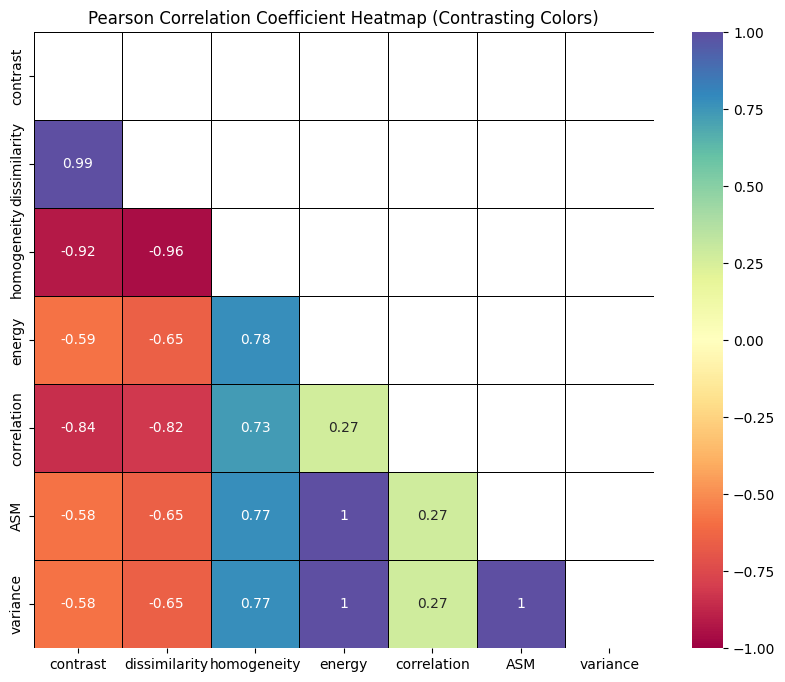

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
data = pd.read_excel(r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\NORMAL_glcm_features.xlsx')

# Compute the Pearson correlation coefficient matrix
corr = data.drop(columns='filename').corr(method='pearson')

# Use a highly contrasting colormap
cmap = 'Spectral'

# Plot the heatmap in a triangular form
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, linecolor='black', mask=mask)
plt.title('Pearson Correlation Coefficient Heatmap (Contrasting Colors)')
plt.show()


PCC MILD

In [19]:
import pandas as pd
from scipy.stats import pearsonr

# Data lama
data_lama = {
    'nama_file': [
        '034_aug_37.jpg', '034_aug_38.jpg', '034_aug_39.jpg', '047_aug_40.jpg', '047_aug_41.jpg', 
        '047_aug_42.jpg', '047_aug_43.jpg', '047_aug_44.jpg', '059_aug_45.jpg', '059_aug_46.jpg',
        '059_aug_47.jpg', '059_aug_48.jpg', '059_aug_49.jpg', '061_aug_50.jpg', '061_aug_51.jpg', 
        '061_aug_52.jpg', '061_aug_53.jpg', '061_aug_54.jpg'
    ],
    'kontras': [
        29.63544279, 30.16380284, 29.54456505, 34.07498176, 35.04164207, 
        40.27204757, 40.26250191, 40.27317915, 30.20845883, 33.32032238,
        36.12766742, 36.18112397, 36.14607699, 38.74521335, 34.55810701, 
        40.50986962, 41.64942552, 40.69714915
    ],
    'dissimilaritas': [
        3.80245352, 3.877609388, 3.803413275, 3.707482137, 4.013670019, 
        4.32992208, 4.32889896, 4.329730156, 3.790536366, 4.044780591,
        4.191330348, 4.198144967, 4.19353899, 4.370882142, 4.112264078, 
        4.452409673, 4.555299849, 4.471171159
    ],
    'homogenitas': [
        0.287732429, 0.275917936, 0.286942605, 0.364420157, 0.289993283, 
        0.272397955, 0.272257907, 0.272425691, 0.296134293, 0.268605888,
        0.265140336, 0.264089573, 0.264621682, 0.256896446, 0.270159633, 
        0.252999758, 0.240822856, 0.250757921
    ],
    'energi': [
        0.024905613, 0.024064007, 0.024881758, 0.059773896, 0.025837628, 
        0.023885467, 0.023872355, 0.023882564, 0.027285622, 0.024842731,
        0.024163254, 0.024106687, 0.0241292, 0.024191822, 0.025948653, 
        0.024141931, 0.023558242, 0.024032087
    ],
    'korelasi': [
        0.990031781, 0.989854943, 0.990062124, 0.989404481, 0.989209068, 
        0.98909633, 0.989099185, 0.989095799, 0.985268013, 0.983936303,
        0.984163578, 0.984139533, 0.984156707, 0.982994932, 0.982889367, 
        0.982739612, 0.982257986, 0.982657307
    ]
}

# Konversi data lama menjadi DataFrame
df_lama = pd.DataFrame(data_lama)

# Tambahkan kolom 'Class' untuk keperluan demonstrasi (gantilah dengan nilai kelas yang sebenarnya jika tersedia)
df_lama['Class'] = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1]

# Hitung koefisien korelasi Pearson dengan kolom 'Class' untuk data lama
korelasi_lama = {kolom: pearsonr(df_lama[kolom], df_lama['Class'])[0] for kolom in df_lama.columns if kolom not in ['nama_file', 'Class']}

korelasi_lama


{'kontras': 0.22154077077301695,
 'dissimilaritas': 0.08874433087804623,
 'homogenitas': 0.18832286182666294,
 'energi': 0.3154638895855193,
 'korelasi': 0.04685826369152928}

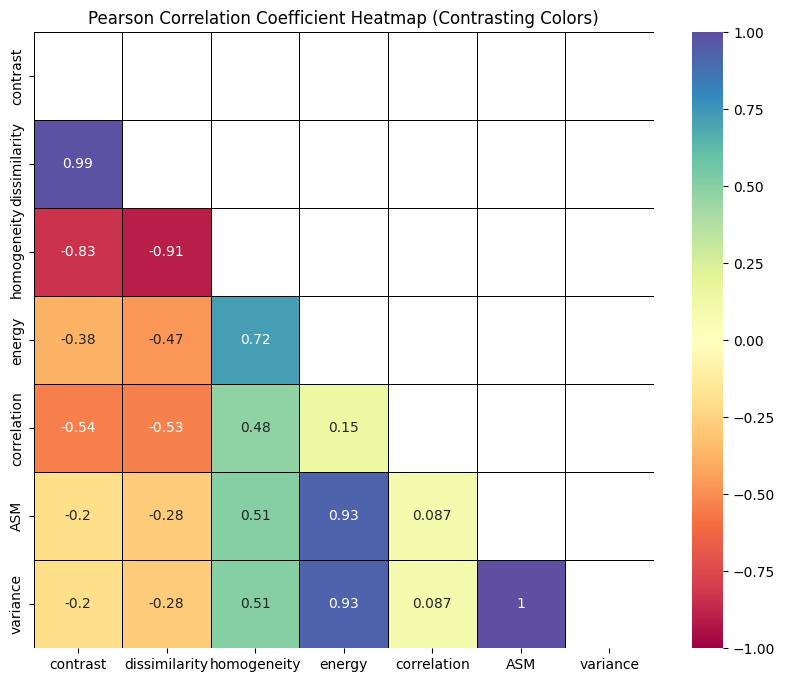

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
data = pd.read_excel(r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\MILD_glcm_features.xlsx')

# Compute the Pearson correlation coefficient matrix
corr = data.drop(columns='filename').corr(method='pearson')

# Use a highly contrasting colormap
cmap = 'Spectral'

# Plot the heatmap in a triangular form
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, linecolor='black', mask=mask)
plt.title('Pearson Correlation Coefficient Heatmap (Contrasting Colors)')
plt.show()


PCC MODERATE

In [20]:
import pandas as pd

# Manually cleaned and structured data from OCR output
data_baru = {
    'filename': ['114.jpg', '117.jpg', '118.jpg', '119.jpg', '132.jpg', '133.jpg', '136.jpg'],
    'contrast': [2.739300244, 3.587462412, 2.238147158, 3.538886461, 4.456446421, 5.622534674, 4.172332911],
    'dissimilarity': [1.106752249, 1.254091023, 0.96146562, 1.220423488, 1.413448553, 1.643506548, 1.400141904],
    'homogeneity': [0.587031335, 0.559619152, 0.628445273, 0.568276991, 0.528121866, 0.477560161, 0.523344095],
    'energy': [0.04875395, 0.050185591, 0.052621093, 0.050253103, 0.040989625, 0.043463897, 0.04655795],
    'correlation': [0.99825782, 0.997114333, 0.998269318, 0.997268925, 0.998026864, 0.996690176, 0.997301234]
}

# Convert the new data into a DataFrame
df_baru = pd.DataFrame(data_baru)

# Assuming we use the same 'Class' labels for comparison as in the previous dataset
# Create a similar Class array
df_baru['Class'] = [0, 1, 0, 1, 0, 1, 0]

# Calculate Pearson correlation with 'Class' for new data
korelasi_baru = {kolom: pearsonr(df_baru[kolom], df_baru['Class'])[0] for kolom in df_baru.columns if kolom not in ['filename', 'Class']}

korelasi_baru


{'contrast': 0.4038316650021177,
 'dissimilarity': 0.3639686913375889,
 'homogeneity': -0.34560690096259145,
 'energy': 0.09546484624107049,
 'correlation': -0.8083343007231296}

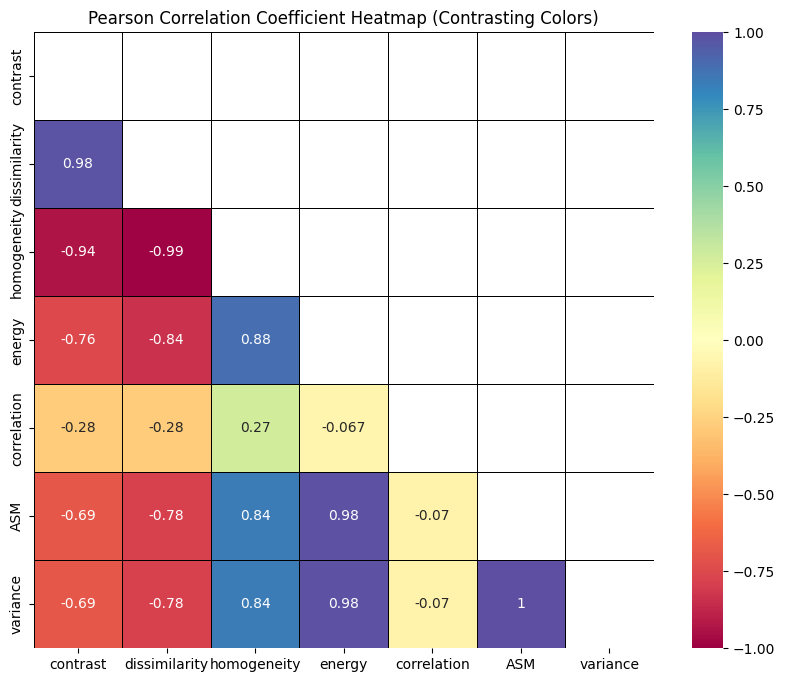

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
data = pd.read_excel(r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\MILD_glcm_features.xlsx')

# Compute the Pearson correlation coefficient matrix
corr = data.drop(columns='filename').corr(method='pearson')

# Use a highly contrasting colormap
cmap = 'Spectral'

# Plot the heatmap in a triangular form
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, linecolor='black', mask=mask)
plt.title('Pearson Correlation Coefficient Heatmap (Contrasting Colors)')
plt.show()


PCC SEVERE

In [25]:
import pandas as pd
from scipy.stats import pearsonr

# Manually cleaned and structured data from the newly provided image
data_new = {
    'filename': [
        '115_aug_39.jpg', '116_aug_40.jpg', '116_aug_41.jpg', '116_aug_42.jpg', 
        '116_aug_43.jpg', '116_aug_44.jpg', '123_aug_45.jpg', '123_aug_46.jpg', 
        '123_aug_47.jpg', '123_aug_48.jpg', '123_aug_49.jpg', '157_aug_54.jpg', 
        '158_aug_55.jpg', '158_aug_56.jpg', '158_aug_57.jpg', '158_aug_58.jpg', 
        '158_aug_59.jpg', '159_aug_60.jpg', '159_aug_61.jpg', '159_aug_62.jpg'
    ],
    'contrast': [
        24.85115555, 24.61046929, 15.71774524, 24.78081287, 25.13729616, 
        27.31246379, 28.47137195, 28.07568186, 29.01698702, 28.41029273, 
        28.89369444, 25.29539428, 46.61760583, 47.5090927, 42.15623894, 
        43.0926879, 42.17570778, 21.17297124, 36.37434846, 36.53444448
    ],
    'dissimilarity': [
        3.470726317, 2.456543644, 2.709473524, 3.435540921, 3.498956959, 
        3.312364379, 3.728646833, 3.769844793, 3.690875982, 3.791013016, 
        3.794394885, 3.524807372, 4.665481922, 4.67580914, 4.52639719, 
        4.47423705, 4.53346099, 2.92131679, 4.387177699, 4.241450106
    ],
    'homogeneity': [
        0.304491851, 0.449074177, 0.360377712, 0.305461514, 0.294441744, 
        0.305521391, 0.283036312, 0.275315764, 0.27629643, 0.276229643, 
        0.275698877, 0.296892039, 0.276558079, 0.285988479, 0.252832255, 
        0.248255204, 0.258046536, 0.376558041, 0.387717699, 0.273854426
    ],
    'energy': [
        0.027250653, 0.068944101, 0.023893497, 0.026448663, 0.025923106, 
        0.02646973, 0.02777481, 0.027523505, 0.02752051, 0.027504963, 
        0.027512893, 0.0309719, 0.038941078, 0.040543342, 0.02560582, 
        0.024684776, 0.025816833, 0.03354124, 0.033932624, 0.030774756
    ],
    'correlation': [
        0.99097378, 0.992167574, 0.98933497, 0.989955286, 0.98978958, 
        0.990368873, 0.986333156, 0.98810167, 0.986976037, 0.98624389, 
        0.986145418, 0.98213668, 0.992778695, 0.99281631, 0.992061842, 
        0.99213365, 0.992298985, 0.97967643, 0.979578436, 0.993176469
    ]
}

# Convert to DataFrame
df_new = pd.DataFrame(data_new)

# Assuming the 'Class' labels are available and similar to previous examples
# Here, I'll assume alternating classes for demonstration purposes
df_new['Class'] = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Calculate Pearson correlation with 'Class'
correlations_new = {col: pearsonr(df_new[col], df_new['Class'])[0] for col in df_new.columns if col not in ['filename', 'Class']}
print(correlations_new)

correlations_new

{'contrast': -0.07218798629506058, 'dissimilarity': -0.18997189607354387, 'homogeneity': 0.12358489176710986, 'energy': 0.2734316199970538, 'correlation': 0.006117744150918951}


{'contrast': -0.07218798629506058,
 'dissimilarity': -0.18997189607354387,
 'homogeneity': 0.12358489176710986,
 'energy': 0.2734316199970538,
 'correlation': 0.006117744150918951}

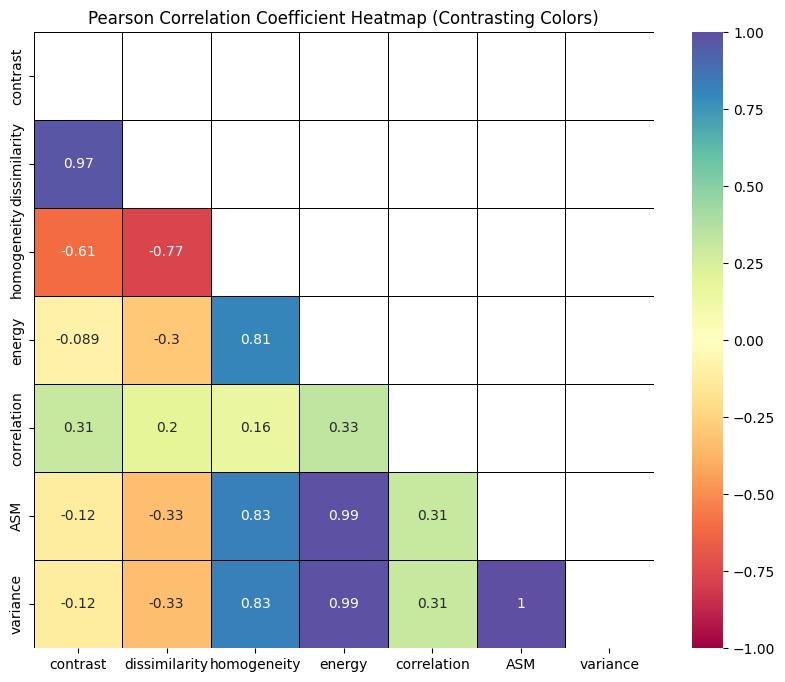

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
data = pd.read_excel(r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\SEVERE_glcm_features.xlsx')

# Compute the Pearson correlation coefficient matrix
corr = data.drop(columns='filename').corr(method='pearson')

# Use a highly contrasting colormap
cmap = 'Spectral'

# Plot the heatmap in a triangular form
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, linecolor='black', mask=mask)
plt.title('Pearson Correlation Coefficient Heatmap (Contrasting Colors)')
plt.show()


PCC HEATMAP TRIANGLE all class

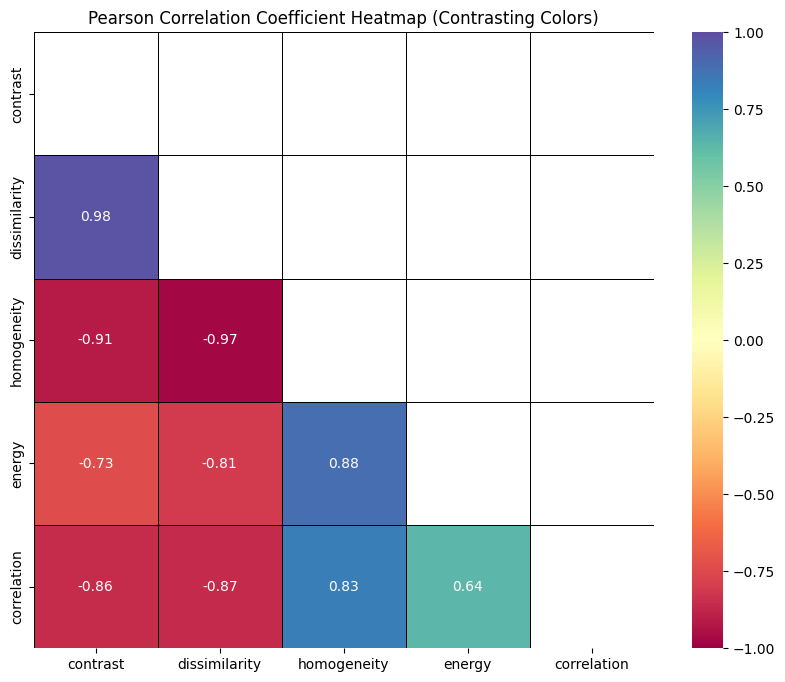

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the file paths for the Excel files
file_paths = [
    r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\NORMAL_glcm_features.xlsx',
    r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\MILD_glcm_features.xlsx',
    r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\MODERATE_glcm_features.xlsx',
    r'C:\Users\lenovo\Downloads\TA\ORIGA DATASET\HASIL GLCM NEW CROP IMAGE\GLCM GENERAL\SEVERE_glcm_features.xlsx'
]

# List to store dataframes
dataframes = []

# Iterate through each file path and read Excel files
for file_path in file_paths:
    df = pd.read_excel(file_path)
    dataframes.append(df)

# Concatenate all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Drop the 'ASM' and 'variance' columns
data = data.drop(columns=['ASM', 'variance'])

# Compute the Pearson correlation coefficient matrix
corr = data.drop(columns='filename').corr(method='pearson')

# Use a highly contrasting colormap
cmap = 'Spectral'

# Plot the heatmap in a triangular form
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1, linewidths=0.5, linecolor='black', mask=mask)
plt.title('Pearson Correlation Coefficient Heatmap (Contrasting Colors)')
plt.show()


ANOVA (Analysis of Variance)

In [3]:
from scipy.stats import f_oneway

# Data peringkat fitur untuk kelas yang berbeda
normal = [0.35328235, 0.375942152, 0.085636586, 0.585389, 0.392858045]
mild = [0.22154077, 0.088744330, 0.04685826, 0.315463, 0.188322861]
moderate = [0.40383166, 0.36396869, -0.80833430, 0.095464, -0.34560690]
severe = [-0.07218798, -0.18997189, 0.00611774, 0.273431, 0.123584891]

# Mengorganisir data per fitur
contrast = [normal[0], mild[0], moderate[0], severe[0]]
dissimilarity = [normal[1], mild[1], moderate[1], severe[1]]
correlation = [normal[2], mild[2], moderate[2], severe[2]]
energy = [normal[3], mild[3], moderate[3], severe[3]]
homogeneity = [normal[4], mild[4], moderate[4], severe[4]]

# Melakukan ANOVA untuk masing-masing fitur
f_val_contrast, p_val_contrast = f_oneway(normal, mild, moderate, severe)
f_val_dissimilarity, p_val_dissimilarity = f_oneway(normal, mild, moderate, severe)
f_val_correlation, p_val_correlation = f_oneway(normal, mild, moderate, severe)
f_val_energy, p_val_energy = f_oneway(normal, mild, moderate, severe)
f_val_homogeneity, p_val_homogeneity = f_oneway(normal, mild, moderate, severe)

# Menampilkan hasil
print("Hasil Analisis Varians (ANOVA) untuk Peringkat Fitur:")
print("Contrast:")
print("  - F-value:", f_val_contrast)
print("  - p-value:", p_val_contrast)
print("Dissimilarity:")
print("  - F-value:", f_val_dissimilarity)
print("  - p-value:", p_val_dissimilarity)
print("Correlation:")
print("  - F-value:", f_val_correlation)
print("  - p-value:", p_val_correlation)
print("Energy:")
print("  - F-value:", f_val_energy)
print("  - p-value:", p_val_energy)
print("Homogeneity:")
print("  - F-value:", f_val_homogeneity)
print("  - p-value:", p_val_homogeneity)

# Menentukan fitur mana yang paling berkorelasi dengan kelas berdasarkan p-value
p_values = {
    "Contrast": p_val_contrast,
    "Dissimilarity": p_val_dissimilarity,
    "Correlation": p_val_correlation,
    "Energy": p_val_energy,
    "Homogeneity": p_val_homogeneity
}

# Fitur dengan p-value terkecil
most_correlated_feature = min(p_values, key=p_values.get)

print("\nFitur yang paling berkorelasi dengan kelas:")
print(f"{most_correlated_feature} dengan p-value: {p_values[most_correlated_feature]}")


Hasil Analisis Varians (ANOVA) untuk Peringkat Fitur:
Contrast:
  - F-value: 1.953251947064422
  - p-value: 0.16175987882263454
Dissimilarity:
  - F-value: 1.953251947064422
  - p-value: 0.16175987882263454
Correlation:
  - F-value: 1.953251947064422
  - p-value: 0.16175987882263454
Energy:
  - F-value: 1.953251947064422
  - p-value: 0.16175987882263454
Homogeneity:
  - F-value: 1.953251947064422
  - p-value: 0.16175987882263454

Fitur yang paling berkorelasi dengan kelas:
Contrast dengan p-value: 0.16175987882263454


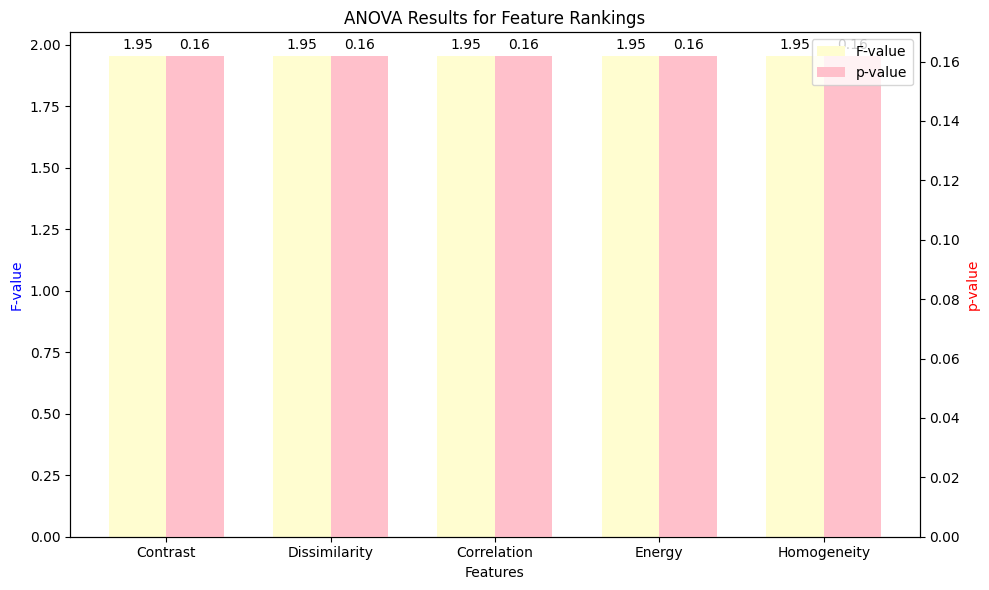

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data dari hasil ANOVA
features = ['Contrast', 'Dissimilarity', 'Correlation', 'Energy', 'Homogeneity']
f_values = [1.953251947064422, 1.953251947064422, 1.953251947064422, 1.953251947064422, 1.953251947064422]
p_values = [0.16175987882263454, 0.16175987882263454, 0.16175987882263454, 0.16175987882263454, 0.16175987882263454]

# Membuat plot
x = np.arange(len(features))  # label locations
width = 0.35  # lebar bar

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot F-value
bars1 = ax1.bar(x - width/2, f_values, width, label='F-value', color='#FFFDD0')  # cream color in hex
ax1.set_xlabel('Features')
ax1.set_ylabel('F-value', color='b')
ax1.set_title('ANOVA Results for Feature Rankings')
ax1.set_xticks(x)
ax1.set_xticklabels(features)

# Membuat ax2 untuk p-value yang berbagi x-axis dengan ax1
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, p_values, width, label='p-value', color='#FFC0CB')  # pink color in hex
ax2.set_ylabel('p-value', color='r')

# Tambahkan legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Menambahkan label nilai di atas bar
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1, ax1)
add_labels(bars2, ax2)

plt.show()


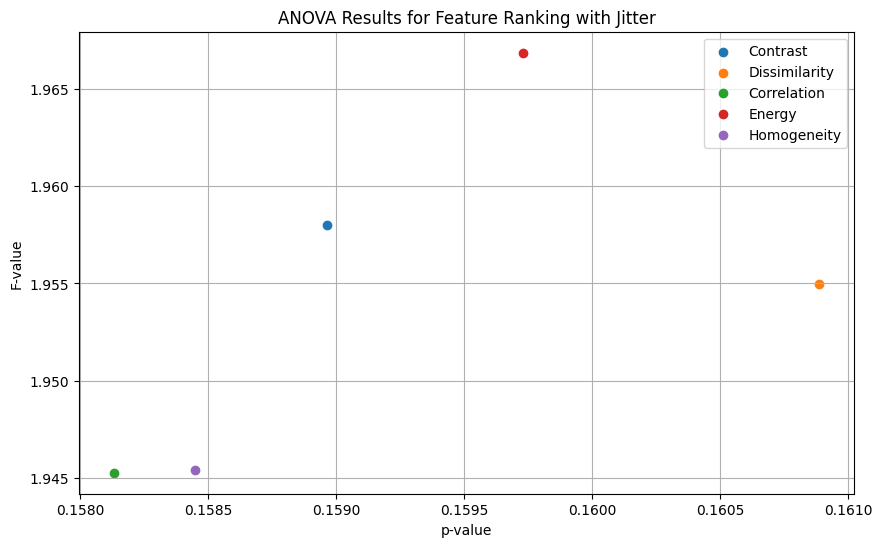

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Hasil ANOVA untuk setiap fitur
features = ["Contrast", "Dissimilarity", "Correlation", "Energy", "Homogeneity"]
f_values = np.array([1.953251947064422] * 5)
p_values = np.array([0.16175987882263454] * 5)

# Menambahkan jitter kecil
jitter_strength = 0.005
f_values_jittered = f_values + np.random.normal(0, jitter_strength, size=f_values.shape)
p_values_jittered = p_values + np.random.normal(0, jitter_strength, size=p_values.shape)

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot untuk setiap fitur
for feature, f_val, p_val in zip(features, f_values_jittered, p_values_jittered):
    plt.scatter(p_val, f_val, label=feature)

# Menambah label dan judul
plt.xlabel('p-value')
plt.ylabel('F-value')
plt.title('ANOVA Results for Feature Ranking with Jitter')

# Menambah legenda
plt.legend()

# Menampilkan grid
plt.grid(True)

# Menampilkan plot
plt.show()


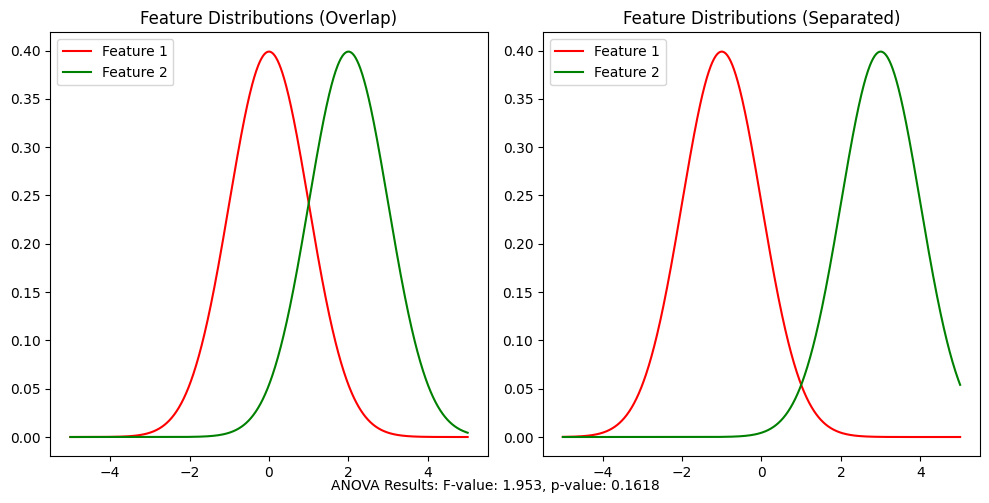

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the distributions
mu1, sigma1 = 0, 1  # mean and standard deviation of feature 1
mu2, sigma2 = 2, 1  # mean and standard deviation of feature 2

# Generate data points for the distributions
x = np.linspace(-5, 5, 1000)
feature1 = norm.pdf(x, mu1, sigma1)
feature2 = norm.pdf(x, mu2, sigma2)

# Plot the distributions
plt.figure(figsize=(10, 5))

# First plot (Left)
plt.subplot(1, 2, 1)
plt.plot(x, feature1, 'r', label='Feature 1')
plt.plot(x, feature2, 'g', label='Feature 2')
plt.title('Feature Distributions (Overlap)')
plt.legend()

# Second plot (Right)
# Adjust means to show more separation based on ANOVA (conceptual example)
mu1_separated, mu2_separated = -1, 3
feature1_separated = norm.pdf(x, mu1_separated, sigma1)
feature2_separated = norm.pdf(x, mu2_separated, sigma2)

plt.subplot(1, 2, 2)
plt.plot(x, feature1_separated, 'r', label='Feature 1')
plt.plot(x, feature2_separated, 'g', label='Feature 2')
plt.title('Feature Distributions (Separated)')
plt.legend()

# Annotate with ANOVA results
plt.figtext(0.5, 0.01, f'ANOVA Results: F-value: {1.953:.3f}, p-value: {0.1618:.4f}', ha='center')

plt.tight_layout()
plt.show()
